<a href="https://colab.research.google.com/github/Aisyaululasmi/Assignment/blob/main/pacman_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tugas 3.1 Searching Solution
##Prinsip Kecerdasan Artifisial


###Nama : Aisya Ulul Asmi
###NIM : 25/564969/PPA/07123

=== PAC-MAN BEAM SEARCH SOLVER ===
Membuat sample mazes...

MENYELESAIKAN MAZE 1
Posisi awal: (1, 1)
Jumlah makanan: 15
Ukuran maze: 7x8

Visualisasi maze awal:


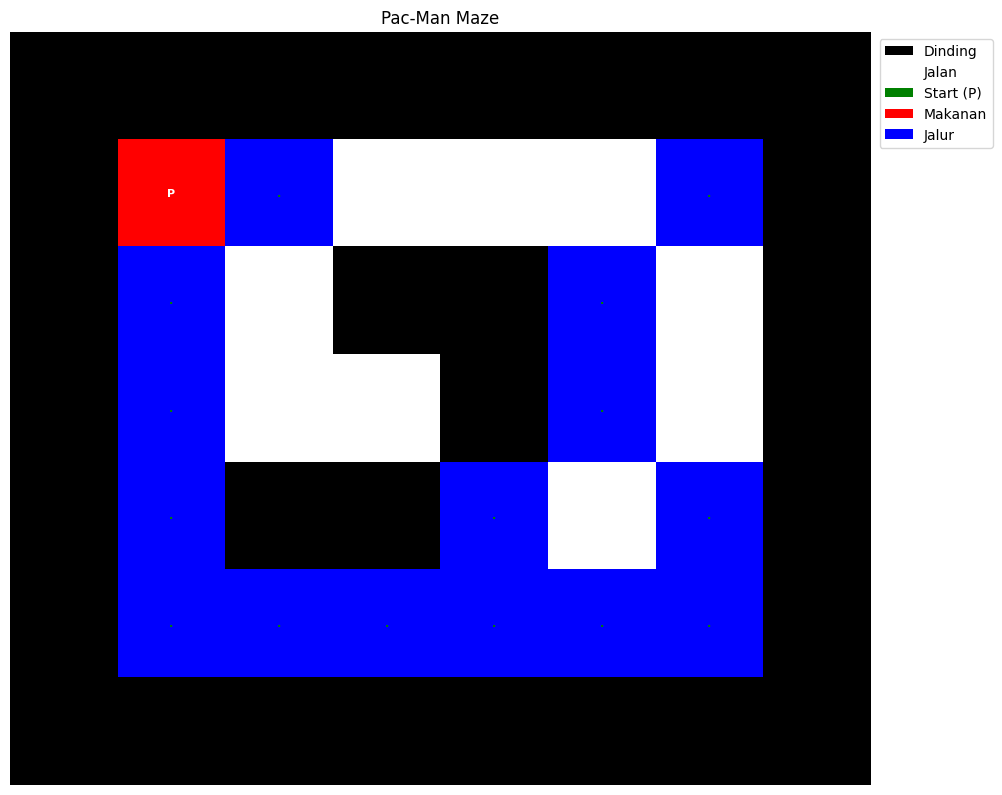

Memulai Beam Search dengan beam_width=1000...
Progress: 1/15 makanan terkumpul
Progress: 2/15 makanan terkumpul
Progress: 3/15 makanan terkumpul
Progress: 4/15 makanan terkumpul
Progress: 5/15 makanan terkumpul
Progress: 6/15 makanan terkumpul
Progress: 7/15 makanan terkumpul
Progress: 8/15 makanan terkumpul
Progress: 9/15 makanan terkumpul
Progress: 10/15 makanan terkumpul
Progress: 11/15 makanan terkumpul
Progress: 12/15 makanan terkumpul
Progress: 13/15 makanan terkumpul
Progress: 14/15 makanan terkumpul
Progress: 15/15 makanan terkumpul
Solusi ditemukan! Waktu: 0.37 detik

=== STATISTIK SOLUSI ===
Panjang jalur: 20 steps
Makanan terkumpul: 15/15
Efisiensi: 75.0% (makanan/step)
Posisi unik yang dikunjungi: 20
Coverage: 35.7% dari maze

Visualisasi solusi:


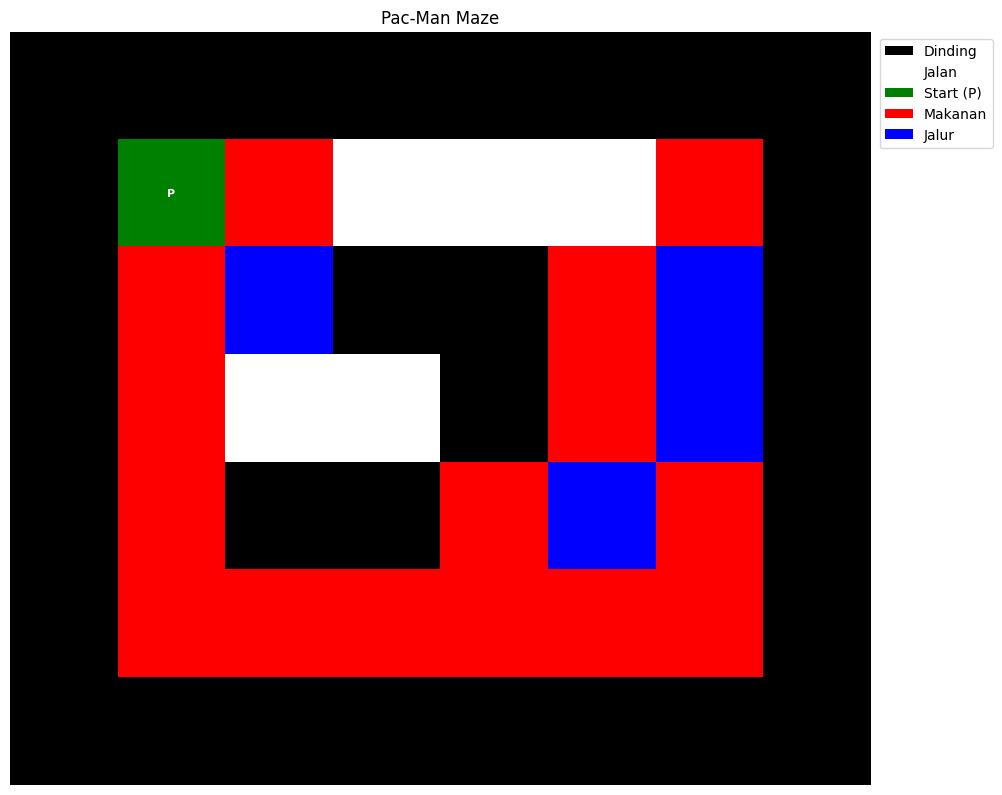


Animasi jalur (10 steps pertama):
Step 0: (1, 1)
Step 1: (1, 2)
Step 2: (2, 2)
Step 3: (2, 1)
Step 4: (3, 1)
Step 5: (4, 1)
Step 6: (5, 1)
Step 7: (5, 2)
Step 8: (5, 3)
Step 9: (5, 4)

MENYELESAIKAN MAZE 2
Posisi awal: (1, 1)
Jumlah makanan: 22
Ukuran maze: 9x12

Visualisasi maze awal:


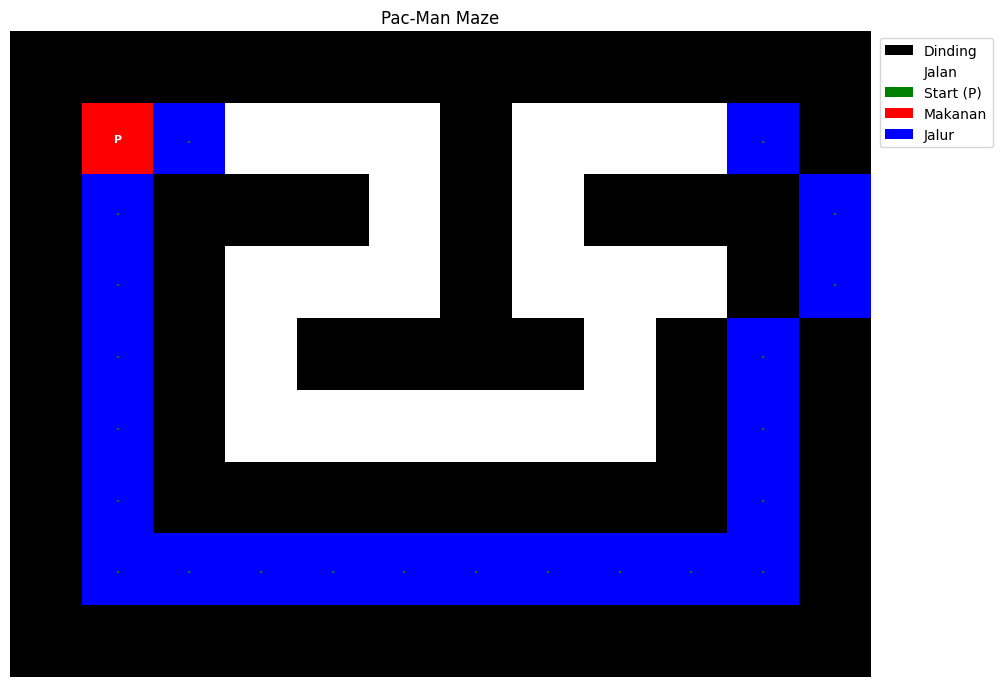

Memulai Beam Search dengan beam_width=1000...
Progress: 1/22 makanan terkumpul
Progress: 2/22 makanan terkumpul
Progress: 3/22 makanan terkumpul
Progress: 4/22 makanan terkumpul
Progress: 5/22 makanan terkumpul
Progress: 6/22 makanan terkumpul
Progress: 7/22 makanan terkumpul
Progress: 8/22 makanan terkumpul
Progress: 9/22 makanan terkumpul
Progress: 10/22 makanan terkumpul
Progress: 11/22 makanan terkumpul
Progress: 12/22 makanan terkumpul
Progress: 13/22 makanan terkumpul
Progress: 14/22 makanan terkumpul
Progress: 15/22 makanan terkumpul
Progress: 16/22 makanan terkumpul
Progress: 17/22 makanan terkumpul
Progress: 18/22 makanan terkumpul
Progress: 19/22 makanan terkumpul
Step 100: Beam size=1000, Best food collected=19
Step 200: Beam size=1000, Best food collected=19
Step 300: Beam size=1000, Best food collected=19
Step 400: Beam size=1000, Best food collected=19
Step 500: Beam size=1000, Best food collected=19
Step 600: Beam size=1000, Best food collected=19
Step 700: Beam size=100

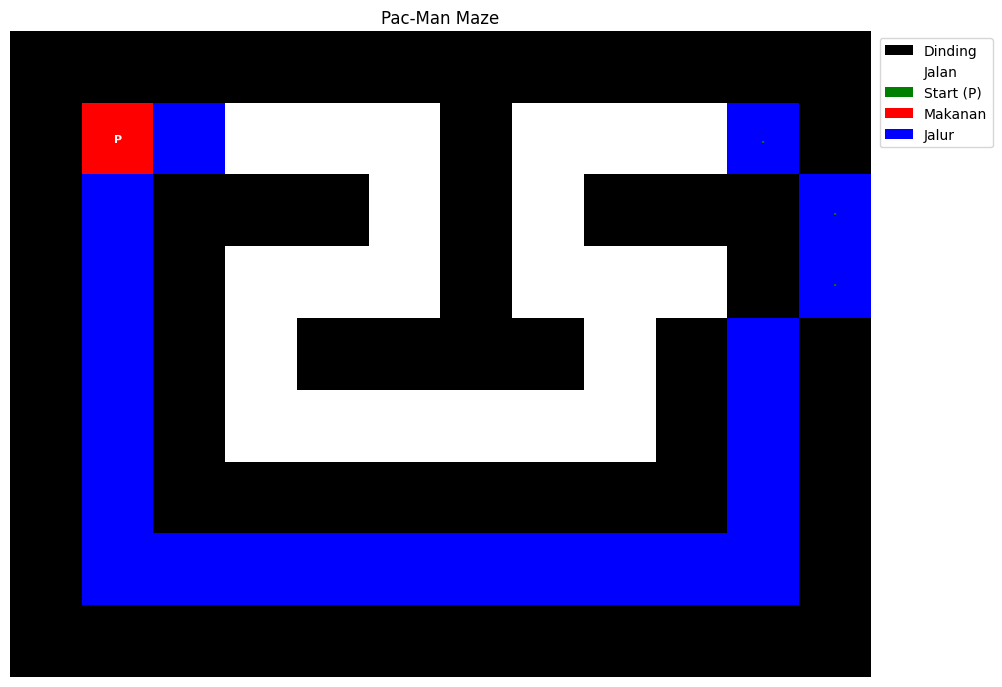


Animasi jalur (10 steps pertama):
Step 0: (1, 1)
Step 1: (1, 2)
Step 2: (1, 1)
Step 3: (2, 1)
Step 4: (3, 1)
Step 5: (4, 1)
Step 6: (5, 1)
Step 7: (6, 1)
Step 8: (7, 1)
Step 9: (7, 2)


In [1]:
import heapq
import time
from collections import deque
import numpy as np
from typing import List, Tuple, Set, Dict, Optional
import matplotlib.pyplot as plt
from matplotlib import colors

class PacManBeamSolver:
    # Inisialisasi Pac-Man solver dengan Beam Search
    def __init__(self, maze: List[str]):
        self.maze = [list(row) for row in maze]
        self.rows = len(self.maze)
        self.cols = len(self.maze[0])
        self.start_pos = None
        self.food_positions = set()

        # Find start position and food
        for r in range(self.rows):
            for c in range(self.cols):
                if self.maze[r][c] == 'P':
                    self.start_pos = (r, c)
                elif self.maze[r][c] == '.':
                    self.food_positions.add((r, c))

        if not self.start_pos:
            raise ValueError("Posisi awal Pac-Man 'P' tidak ditemukan!")

        print(f"Posisi awal: {self.start_pos}")
        print(f"Jumlah makanan: {len(self.food_positions)}")
        print(f"Ukuran maze: {self.rows}x{self.cols}")

    # Check validitas posisi
    def is_valid_position(self, r: int, c: int) -> bool:
        return (0 <= r < self.rows and
                0 <= c < self.cols and
                self.maze[r][c] != '#')

    # Get valid neighbor positions
    def get_neighbors(self, r: int, c: int) -> List[Tuple[int, int]]:
        neighbors = []
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # Right, Left, Down, Up

        for dr, dc in directions:
            nr, nc = r + dr, c + dc
            if self.is_valid_position(nr, nc):
                neighbors.append((nr, nc))

        return neighbors

    # Calculate Manhattan distance between two positions
    def manhattan_distance(self, pos1: Tuple[int, int], pos2: Tuple[int, int]) -> int:
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

    # Heuristic function untuk Beam Search (kombinasi nearest food distance dan food cluster estimation)
    def heuristic(self, current_pos: Tuple[int, int], remaining_food: Set[Tuple[int, int]]) -> float:
        if not remaining_food:
            return 0

        # 1. Distance to nearest food
        min_food_dist = min(self.manhattan_distance(current_pos, food) for food in remaining_food)

        # 2. Estimate of remaining path length using minimum spanning tree approximation
        if len(remaining_food) > 1:
            # Simple approximation: farthest food distance * 0.7
            max_food_dist = max(self.manhattan_distance(current_pos, food) for food in remaining_food)
            mst_estimate = max_food_dist * 0.7
        else:
            mst_estimate = 0

        # 3. Food density bonus
        avg_dist = sum(self.manhattan_distance(current_pos, food) for food in remaining_food) / len(remaining_food)
        density_bonus = avg_dist * 0.1

        return min_food_dist + mst_estimate + density_bonus

    # Beam Search algorithm untuk menyelesaikan Pac-Man
    def beam_search(self, beam_width: int = 1000, max_steps: int = 5000) -> Optional[List[Tuple[int, int]]]:
        # beam_width: Jumlah state terbaik yang dipertahankan di setiap step
        # max_steps: Maximum number of steps sebelum timeout

        print(f"Memulai Beam Search dengan beam_width={beam_width}...")
        start_time = time.time()

        # Initial state: (g_cost, position, remaining_food, path)
        initial_state = (0, self.start_pos, frozenset(self.food_positions), [self.start_pos])
        beam = [initial_state]

        # Best solution tracking
        best_solution = None
        best_food_count = len(self.food_positions)

        # Visited states tracking dengan tolerance
        visited = {}

        step = 0
        while beam and step < max_steps:
            step += 1
            if step % 100 == 0:
                print(f"Step {step}: Beam size={len(beam)}, Best food collected={len(self.food_positions) - best_food_count}")

            new_beam = []

            for g_cost, current_pos, remaining_food, path in beam:
                # Check better solution
                current_food_count = len(remaining_food)
                if current_food_count < best_food_count:
                    best_food_count = current_food_count
                    best_solution = path
                    print(f"Progress: {len(self.food_positions) - current_food_count}/{len(self.food_positions)} makanan terkumpul")

                # Goal check
                if not remaining_food:
                    print(f"Solusi ditemukan! Waktu: {time.time() - start_time:.2f} detik")
                    return path

                # Generate next states
                for neighbor in self.get_neighbors(*current_pos):
                    new_g_cost = g_cost + 1
                    new_remaining_food = remaining_food

                    # Check if we collected food
                    if neighbor in remaining_food:
                        new_remaining_food = frozenset(f for f in remaining_food if f != neighbor)

                    new_path = path + [neighbor]

                    # State key untuk visited tracking
                    state_key = (neighbor, new_remaining_food)

                    # Check if we should add this state to new beam
                    if (state_key not in visited or
                        visited[state_key] > new_g_cost or
                        len(new_remaining_food) < visited[state_key]):

                        visited[state_key] = new_g_cost
                        f_cost = new_g_cost + self.heuristic(neighbor, new_remaining_food)
                        new_state = (new_g_cost, neighbor, new_remaining_food, new_path)
                        new_beam.append((f_cost, new_state))

            # Sort by f_cost and keep only beam_width best states
            if new_beam:
                new_beam.sort(key=lambda x: x[0])
                beam = [state for _, state in new_beam[:beam_width]]
            else:
                break

        print(f"Beam Search selesai. Waktu: {time.time() - start_time:.2f} detik")
        return best_solution  # Return best solution found (might be partial)

    # Visualisasi maze
    def visualize_maze(self, path: Optional[List[Tuple[int, int]]] = None):
        # Create color map
        cmap = colors.ListedColormap(['black', 'white', 'green', 'red', 'blue'])

        # Create grid
        grid = np.zeros((self.rows, self.cols))

        for r in range(self.rows):
            for c in range(self.cols):
                if self.maze[r][c] == '#':
                    grid[r, c] = 0  # Wall
                elif self.maze[r][c] == 'P':
                    grid[r, c] = 2  # Start position
                elif self.maze[r][c] == '.':
                    grid[r, c] = 3  # Food
                else:
                    grid[r, c] = 1  # Empty space

        # Mark path if provided
        if path:
            for r, c in path:
                if grid[r, c] == 1:  # Only mark empty spaces as path
                    grid[r, c] = 4  # Path

        # Create plot
        plt.figure(figsize=(10, 10))
        plt.imshow(grid, cmap=cmap, interpolation='nearest')

        # Add labels
        for r in range(self.rows):
            for c in range(self.cols):
                if self.maze[r][c] == 'P':
                    plt.text(c, r, 'P', ha='center', va='center',
                            fontsize=8, fontweight='bold', color='white')
                elif self.maze[r][c] == '.' and (not path or (r, c) not in path):
                    plt.text(c, r, '.', ha='center', va='center',
                            fontsize=8, fontweight='bold', color='green')

        plt.title('Pac-Man Maze')
        plt.axis('off')

        # Add legend
        legend_elements = [
            plt.Rectangle((0, 0), 1, 1, fc='black', label='Dinding'),
            plt.Rectangle((0, 0), 1, 1, fc='white', label='Jalan'),
            plt.Rectangle((0, 0), 1, 1, fc='green', label='Start (P)'),
            plt.Rectangle((0, 0), 1, 1, fc='red', label='Makanan'),
            plt.Rectangle((0, 0), 1, 1, fc='blue', label='Jalur')
        ]
        plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

        plt.tight_layout()
        plt.show()

    # Print solution statistics
    def print_solution_stats(self, path: List[Tuple[int, int]]):
        if not path:
            print("Tidak ada solusi yang ditemukan!")
            return

        # Calculate collected food
        collected_food = 0
        for pos in path:
            if self.maze[pos[0]][pos[1]] == '.':
                collected_food += 1

        print(f"\n=== STATISTIK SOLUSI ===")
        print(f"Panjang jalur: {len(path)} steps")
        print(f"Makanan terkumpul: {collected_food}/{len(self.food_positions)}")
        print(f"Efisiensi: {collected_food/len(path)*100:.1f}% (makanan/step)")

        # Calculate coverage
        unique_positions = len(set(path))
        print(f"Posisi unik yang dikunjungi: {unique_positions}")
        print(f"Coverage: {unique_positions/(self.rows*self.cols)*100:.1f}% dari maze")

# Contoh maze untuk testing
def create_sample_mazes():

    # Maze 1 - Kecil dan sederhana
    maze1 = [
        "########",
        "#P.   .#",
        "#. ##. #",
        "#.  #. #",
        "#.##. .#",
        "#......#",
        "########",
    ]

    # Maze 2 - Sedang
    maze2 = [
        "############",
        "#P.   #   .#",
        "#.### # ###.#",
        "#.#   #   #.#",
        "#.# #### #.#",
        "#.#      #.#",
        "#.########.#",
        "#..........#",
        "############",
    ]

    return [maze1, maze2]

# Main execution function
def main():
    print("=== PAC-MAN BEAM SEARCH SOLVER ===")
    print("Membuat sample mazes...")

    mazes = create_sample_mazes()

    for i, maze in enumerate(mazes, 1):
        print(f"\n{'='*50}")
        print(f"MENYELESAIKAN MAZE {i}")
        print(f"{'='*50}")

        # Create solver instance
        solver = PacManBeamSolver(maze)

        # Visualize initial maze
        print("\nVisualisasi maze awal:")
        solver.visualize_maze()

        # Solve dengan beam search
        beam_width = 500 if i == 3 else 1000
        solution = solver.beam_search(beam_width=beam_width, max_steps=3000)

        # Print statistics
        solver.print_solution_stats(solution)

        # Visualize solution
        if solution:
            print("\nVisualisasi solusi:")
            solver.visualize_maze(solution)

            # Show path animation
            print("\nAnimasi jalur (10 steps pertama):")
            for j, pos in enumerate(solution[:10]):
                print(f"Step {j}: {pos}")
        else:
            print("Tidak ditemukan solusi lengkap, menampilkan partial solution...")
            if hasattr(solver, 'best_solution'):
                solver.visualize_maze(solver.best_solution)

# Fungsi untuk testing performa dengan berbagai beam width
def test_beam_widths():
    print("\n\n=== TESTING BERBAGAI BEAM WIDTH ===")

    maze = create_sample_mazes()[1]  # Gunakan maze sedang

    beam_widths = [100, 500, 1000, 2000]
    results = []

    for beam_width in beam_widths:
        print(f"\nTesting beam_width = {beam_width}")

        solver = PacManBeamSolver(maze)
        start_time = time.time()

        solution = solver.beam_search(beam_width=beam_width, max_steps=2000)

        execution_time = time.time() - start_time
        food_collected = 0

        if solution:
            for pos in solution:
                if solver.maze[pos[0]][pos[1]] == '.':
                    food_collected += 1

        results.append({
            'beam_width': beam_width,
            'time': execution_time,
            'food_collected': food_collected,
            'total_food': len(solver.food_positions),
            'path_length': len(solution) if solution else 0
        })

        print(f"Waktu: {execution_time:.2f}s, Makanan: {food_collected}/{len(solver.food_positions)}")

    # Print results
    print("\n=== HASIL PERBANDINGAN ===")
    for result in results:
        print(f"Beam {result['beam_width']}: {result['time']:.2f}s, "
              f"{result['food_collected']}/{result['total_food']} food, "
              f"{result['path_length']} steps")

# Run the main function
if __name__ == "__main__":
    # Jalankan solver utama
    main()